# Visualize ambiguity

In [17]:
import pandas as pd
from pathlib import Path
# paths = Path('wiki/iawiki-latest/iawiki-latest-paragraph-links').glob('*')
paths = Path('wiki/simplewiki-20211120/simplewiki-20211120-paragraph-links').glob('*')
df = pd.concat([
    pd.read_csv(p, sep='\t', on_bad_lines='skip', names=['page', 'ents', 'text']) 
    for p in paths if p.stat().st_size
], ignore_index=True)
df.shape

(710217, 3)

In [27]:
import json
def loads(x):
    try:
        return json.loads(x)
    except:
        return {}
links = df['ents'].apply(loads).apply(dict.items).explode()
links = pd.DataFrame(links.tolist(), index=links.index, columns=['name', 'qid'])
links['qid'] = links['qid'].astype('Int64').astype('str')

# links.value_counts().groupby(level='name').size().sort_values().tail(20) # number of meanings
links.value_counts().groupby(level='name').nth(1).head(20) # top shadowed meanings

name        qid   
American    30        8300
English     1860      2441
New York    1384      1705
British     842438    1650
footballer  937857    1605
French      150       1435
German      188       1266
Canadian    16        1200
2010        1995       983
Country     6256       878
county      28575      842
Spanish     1321       833
President   11696      812
state       7275       768
Japan       170566     682
R&B         45981      601
football    41323      564
Dutch       200569     516
Georgia     230        500
Italian     652        498
Name: count, dtype: int64

In [31]:
name = 'New York'
sub  = links.loc[links['name'] == name].groupby('qid').filter(lambda x: len(x) > 5)
texts = df.loc[sub.index, 'text']

import requests
def get_description(*ids):
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(['Q%s'%i for i in ids]),
        'languages': 'en',
        'props': 'descriptions',
        'format': 'json',
    }
    resp = requests.get('https://www.wikidata.org/w/api.php', params=params).json()
    return {k:v.get('descriptions', {}).get('en', {}).get('value', None)
            for k,v in resp.get('entities', {}).items()}

qid_desc = {k[1:]:('%9s '%k) + v[:40] for k,v in get_description(*sub['qid'].unique()).items()}

print(sub['qid'].replace(qid_desc).value_counts())

qid
   Q22654 Wikimedia disambiguation page               2724
    Q1384 state of the United States of America       1705
      Q60 most populous city in the United States      319
   Q11299 borough of New York City, New York, Unit      10
Name: count, dtype: int64


(4758, 24038)
Explained variance of the SVD step: 29.5%


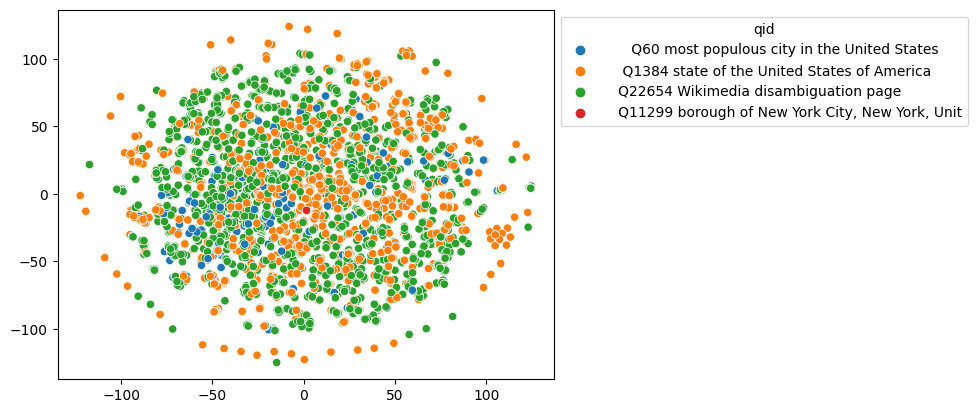

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=3,
    ngram_range=(1,3),
)
X_tfidf = vectorizer.fit_transform(texts)
print(X_tfidf.shape)

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X_lsa)

import seaborn as sns
import numpy as np

ax = sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=sub['qid'].replace(qid_desc))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [33]:
qid_means = pd.DataFrame(X_lsa, index=sub.index).join(sub['qid']).groupby('qid').mean()
original_space_centroids = lsa[0].inverse_transform(qid_means)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i,qid in enumerate(qid_means.index):
    print(f"{qid_desc[qid]:51s}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

   Q11299 borough of New York City, New York, Unit : category it city and in the in new york city new york city in new york establishments 
    Q1384 state of the United States of America    : category and is was american he to from of the states 
   Q22654 Wikimedia disambiguation page            : category and was he to from american is on for 
      Q60 most populous city in the United States  : and to was is category he of the it on by 
